목표

혼합형 특성이 포함된 CarPrice 데이터에서 선형 회귀로 가격을 예측한다. 전처리·인코딩·스케일링을 누수 없이 파이프라인에 캡슐화하고, 정규화로 일반화 성능을 높인다.

브랜드 정규화: CarName에서 첫 토큰을 브랜드로 추출하고 오탈자 교정해 범주형 품질을 개선한다.

전처리: ColumnTransformer로 수치 표준화(StandardScaler), 범주형 OneHotEncoder(handle_unknown="ignore") 구성.

모델: 기본 OLS(LinearRegression) 외 Ridge/Lasso로 계수 수축을 통해 분산 감소 및 해석 안정성 확보.

검증: 홀드아웃 평가와 5-Fold 그리드서치로 하이퍼파라미터 탐색(alpha).

해석: 최종 특성명 복원 후 계수 상·하위 요인 시각화, 잔차 진단으로 선형 가정 확인.

sklearn Pipeline/ColumnTransformer로 훈련 단계에만 fit이 일어나도록 캡슐화하면 재현성·안전성이 높다.

고차원 원-핫 특성은 OLS에서 분산이 커지기 쉬워 Ridge/Lasso가 유리하다. sklearn 예제도 정규화의 이점을 설명한다.


In [1]:
# !pip install -U scikit-learn pandas numpy seaborn matplotlib category_encoders

import sys, platform, sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print({
    "python": sys.version,
    "platform": platform.platform(),
    "sklearn": sklearn.__version__
})

# 소스 데이터: CarPrice_Assignment.csv (여러 깃허브/캐글에 동일 스키마로 공개)
# 아래 두 경로 중 하나를 사용. (로컬 업로드 시 파일명만 변경)
CSV_URLS = [
    "https://raw.githubusercontent.com/pranavhaldar/Car-Price_Linear-Regression-Assignment/master/CarPrice_Assignment.csv",
    # 캐글 데이터셋(수동 다운로드 필요): hellbuoy/car-price-prediction
]

# Read the CSV from the first URL in the list
df = pd.read_csv(CSV_URLS[0])
df.head()

{'python': '3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]', 'platform': 'Linux-6.1.123+-x86_64-with-glibc2.35', 'sklearn': '1.6.1'}


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


최신 버전 기준 sklearn 1.5+ 문법 호환, seaborn/matplotlib로 탐색적 분석 지원.



Shape: (205, 26)
Columns: ['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']
Dtypes:
 car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peak

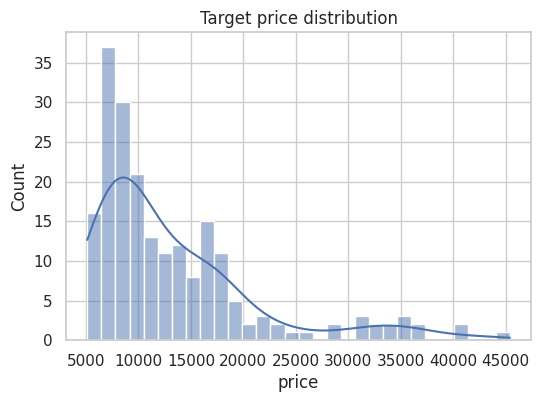

In [2]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Dtypes:\n", df.dtypes)
print("Nulls per column:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# 타깃 분포 확인
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(df["price"], kde=True, bins=30)
plt.title("Target price distribution")
plt.show()


결측치/중복/타입 확인.

In [3]:
df = df.copy()

# 1) CarName에서 첫 토큰을 브랜드로 추출
df["brand"] = df["CarName"].str.split().str[0].str.lower()

# 2) 잘 알려진 오탈자 교정 맵(글에서 언급된 사례 포함)
brand_fix = {
    "maxda": "mazda",
    "porcshce": "porsche",
    "nissan": "nissan",  # 대소문자 변형 대비
    "vokswagen": "volkswagen",
    "vw": "volkswagen",
    "toyouta": "toyota"
}
df["brand"] = df["brand"].replace(brand_fix)

# 참고: 원본 CarName은 유지하거나 제거 가능
# df = df.drop(columns=["CarName"])
df[["CarName","brand"]].head(10)

,CarName,brand
0,alfa-romero giulia,alfa-romero
1,alfa-romero stelvio,alfa-romero
2,alfa-romero Quadrifoglio,alfa-romero
3,audi 100 ls,audi
4,audi 100ls,audi
5,audi fox,audi
6,audi 100ls,audi
7,audi 5000,audi
8,audi 4000,audi
9,audi 5000s (diesel),audi


CarName에서 브랜드명 분리 후 오탈자 교정.

In [4]:
target = "price"

# 식별자/누수 가능 컬럼 제외: car_ID, CarName (브랜드로 대체), price(타깃)
drop_cols = ["car_ID", "CarName", target]

X = df.drop(columns=drop_cols, errors="ignore")
y = df[target].astype(float)

# 범주형/수치형 컬럼 자동 식별
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand']
Numeric: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']


범주형/수치형을 명확히 분리해 ColumnTransformer에 전달

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

len(X_train), len(X_test)


(143, 62)

재현성 있는 홀드아웃 분할.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

ols_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(random_state=42))
])

lasso_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(random_state=42, max_iter=10000))
])

ols_pipe


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['symboling', 'wheelbase',
                                                   'carlength', 'carwidth',
                                                   'carheight', 'curbweight',
                                                   'enginesize', 'boreratio',
                                                   'stroke', 'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['fueltype', 'aspiration',
                                                   'doornumber', 'carbody',
                                                   'drivewheel',
                                                   'enginelocation',
                                                   'enginetype',
                                                   'cylindernumber',
                                                   'fuelsystem', 'brand'])])),
                ('model', LinearRegression())])

수치: 표준화, 범주형: 원-핫 인코딩

모델: OLS(LinearRegression)와 Ridge/Lasso(일반화) 비교 가능.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(model, X_tr, y_tr, X_te, y_te, name="model"):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    print(f"[{name}]")
    print(" Train MSE:", mean_squared_error(y_tr, pred_tr))
    print(" Train R2 :", r2_score(y_tr, pred_tr))
    print(" Test  MSE:", mean_squared_error(y_te, pred_te))
    print(" Test  R2 :", r2_score(y_te, pred_te))
    return pred_te

pred_ols = evaluate(ols_pipe, X_train, y_train, X_test, y_test, "OLS")


[OLS]
 Train MSE: 1327180.6314953403
 Train R2 : 0.978224955411894
 Test  MSE: 7731402.5515248
 Test  R2 : 0.8884105954835486


MSE/R2를 간단 확인(글의 MSE/R2와 유사 지표).

In [8]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_params = {"model__alpha": np.logspace(-2, 3, 12)}
lasso_params = {"model__alpha": np.logspace(-2, 2, 10)}

ridge_gs = GridSearchCV(ridge_pipe, ridge_params, cv=cv, scoring="r2", n_jobs=-1)
lasso_gs = GridSearchCV(lasso_pipe, lasso_params, cv=cv, scoring="r2", n_jobs=-1)

ridge_gs.fit(X_train, y_train)
lasso_gs.fit(X_train, y_train)

print("Best Ridge:", ridge_gs.best_params_, ridge_gs.best_score_)
print("Best Lasso:", lasso_gs.best_params_, lasso_gs.best_score_)

pred_ridge = evaluate(ridge_gs.best_estimator_, X_train, y_train, X_test, y_test, "Ridge*")
pred_lasso = evaluate(lasso_gs.best_estimator_, X_train, y_train, X_test, y_test, "Lasso*")


Best Ridge: {'model__alpha': np.float64(0.23101297000831592)} 0.8984339811052868
Best Lasso: {'model__alpha': np.float64(4.6415888336127775)} 0.8849447952641926
[Ridge*]
 Train MSE: 1407784.5519159657
 Train R2 : 0.9769024873774127
 Test  MSE: 7130718.046549313
 Test  R2 : 0.897080435886472
[Lasso*]
 Train MSE: 1435611.4731277467
 Train R2 : 0.9764459312495151
 Test  MSE: 7463833.324369403
 Test  R2 : 0.8922724938294457


정규화(Ridge/Lasso) 및 하이퍼파라미터 탐색

고차원 원-핫 특성에 정규화가 일반적으로 안정적(과적합/분산 완화).

,feature,coef
52,brand_bmw,6205.772757
53,brand_buick,5324.324532
65,brand_porsche,4215.327065
29,enginelocation_rear,3063.449740
6,enginesize,3031.903633
42,cylindernumber_two,2897.640311
36,enginetype_rotor,2897.640311
58,brand_jaguar,2582.835519
5,curbweight,2550.691372
21,carbody_hardtop,2267.195889


,feature,coef
66,brand_renault,-1864.727266
68,brand_subaru,-1971.321137
24,carbody_wagon,-1984.146266
41,cylindernumber_twelve,-2006.450997
35,enginetype_ohcv,-2030.174354
31,enginetype_dohcv,-2211.607642
55,brand_dodge,-2473.208083
64,brand_plymouth,-2560.628140
61,brand_mitsubishi,-2800.189630
28,enginelocation_front,-3063.449740


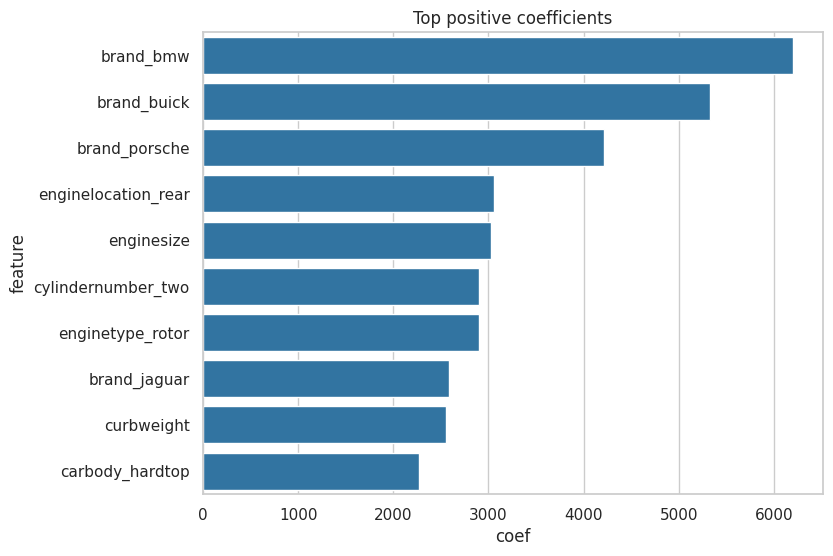

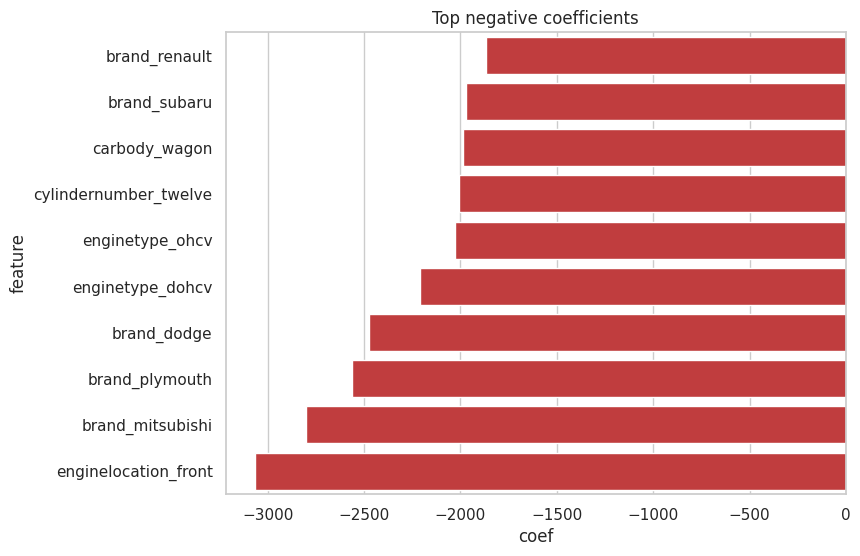

In [9]:
def get_feature_names(preprocess, num_cols, cat_cols):
    num_features = num_cols
    ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

best_model = ridge_gs.best_estimator_  # 해석용으로 Ridge 선택(안정적)
pre = best_model.named_steps["preprocess"]
feat_names = get_feature_names(pre, num_cols, cat_cols)

coefs = best_model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs}).sort_values("coef", ascending=False)

top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

display(top_pos)
display(top_neg)

plt.figure(figsize=(8,6))
sns.barplot(data=top_pos, x="coef", y="feature", color="tab:blue")
plt.title("Top positive coefficients")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(data=top_neg, x="coef", y="feature", color="tab:red")
plt.title("Top negative coefficients")
plt.show()


ColumnTransformer+OHE의 최종 특성명을 복원해 계수 상위/하위 확인.

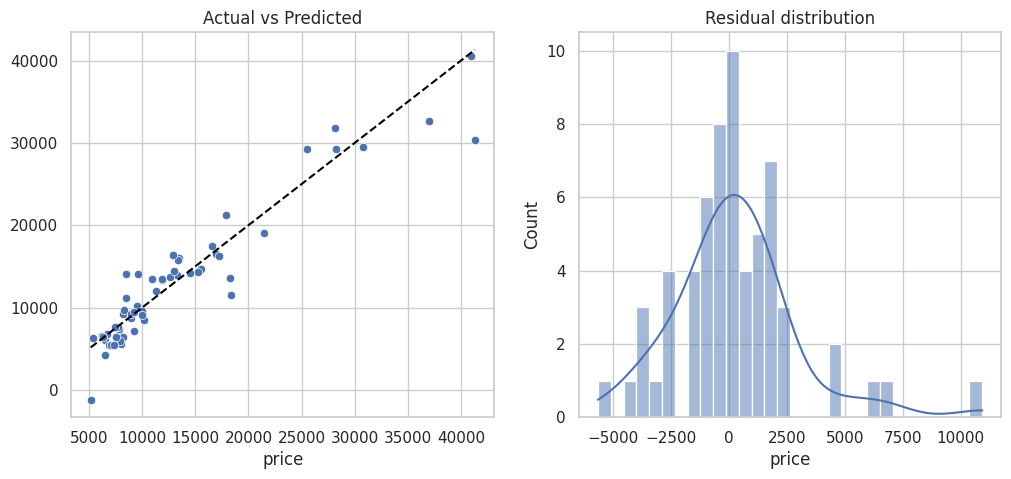

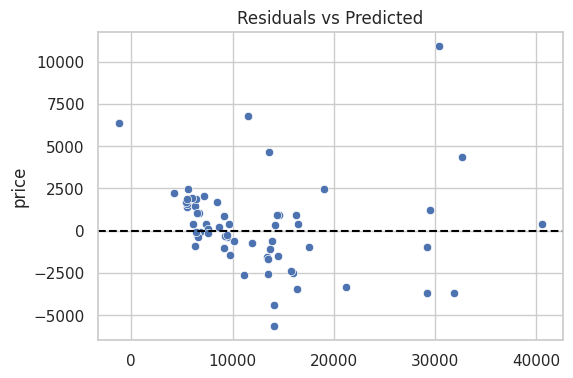

In [10]:
final_model = best_model  # Ridge 최적 모델
y_pred = final_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="black", linestyle="--")
axes[0].set_title("Actual vs Predicted")

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30, ax=axes[1])
axes[1].set_title("Residual distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals vs Predicted")
plt.show()

예측 대 실제, 잔차 분포/패턴 확인으로 선형 가정 위반 여부 점검

In [11]:
rng = np.random.default_rng(42)
baseline_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
baseline_rand = rng.uniform(low=y_train.min(), high=y_train.max(), size=y_test.shape)

def metrics(y_true, y_hat, name):
    print(f"[{name}] MSE={mean_squared_error(y_true, y_hat):.2f}  R2={r2_score(y_true, y_hat):.3f}")

metrics(y_test, baseline_mean, "Baseline-Mean")
metrics(y_test, baseline_rand, "Baseline-Random")
metrics(y_test, y_pred, "Model-Ridge*")


[Baseline-Mean] MSE=69474271.43  R2=-0.003
[Baseline-Random] MSE=411292341.63  R2=-4.936
[Model-Ridge*] MSE=7130718.05  R2=0.897


평균 예측·랜덤 예측 대비 성능 비교로 모델 유의미성 확인.

왜 MSE가 크게 나오는가

타깃 스케일의 영향:  

MSE는 단위가 가격² 이므로 절대값이 크게 보이는 것이 정상입니다. 예컨대 평균 절대 오차가 수천 단위면 제곱을 취한 MSE는 수백만~수천만이 됩니다. 이 자체가 “나쁜 모델”을 의미하진 않습니다. R²로 상대 성능을 함께 봐야 합니다.

이분산성(heteroscedasticity):

자동차 가격은 고가일수록 변동 폭이 커지는 경향이 있어, 동일한 상대 오차라도 고가에서 큰 절대 오차로 나타나 MSE가 커집니다. 파워 변환(예: Yeo-Johnson/Box-Cox)이나 로그 변환이 잔차의 등분산을 돕습니다.

선형성 한계·상호작용 누락:

원-핫으로 고차원화된 특징에서 완전한 선형 관계가 성립하지 않거나 상호작용/비선형이 필요하면 OLS의 잔차가 커집니다(규제로 다소 완화 가능). 필요 시 PCA로 다중공선성을 완화하거나 차원 축소 후 선형 회귀를 적용할 수 있습니다.

개선 전략

타깃 로그 변환:  $y$ 를 $log(y)$ 로 학습하면 상대 오차를 최소화하는 효과가 있어 고가 영역 잔차가 안정됩니다. 예측 시 지수 역변환으로 원 단위 복원합니다.

파워 변환/분산 안정화:  수치 피처에 PowerTransformer(Yeo-Johnson/Box-Cox)를 적용해 정규성·등분산성에 가까워지도록 합니다.

규제 재탐색: Ridge/Lasso의 알파 공간을 더 촘촘히/넓게 탐색하면 일반화 성능이 소폭 개선될 수 있습니다.

특성 공학·차원 축소: 상호작용항(예: 배기량×차폭), 다항항, 혹은 PCA+OLS로 다중공선성과 잡음을 줄여 해석가능한 개선을 시도합니다.

평가 지표 보강: R², RMSE 외에 MAPE/MedAE도 병행해 “체감 오차”를 확인합니다(가격 문제에서 유용).

## 로그-타깃 파이프라인 추가
로그 타깃을 학습하고, 예측 시 지수로 되돌리는 TransformedTargetRegressor 사용.

In [12]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

# 로그-타깃 변환기 (y>0이므로 안전)
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)

ols_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p, inverse_func=np.expm1))
])

ridge_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1))
])

lasso_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=Lasso(random_state=42, max_iter=10000),
        func=np.log1p, inverse_func=np.expm1))
])

# 평가
print("=== Log-Target Models ===")
_ = evaluate(ols_log, X_train, y_train, X_test, y_test, "OLS (log-target)")
_ = evaluate(ridge_log, X_train, y_train, X_test, y_test, "Ridge (log-target)")
_ = evaluate(lasso_log, X_train, y_train, X_test, y_test, "Lasso (log-target)")


=== Log-Target Models ===
[OLS (log-target)]
 Train MSE: 1207509.2552926228
 Train R2 : 0.980188402956934
 Test  MSE: 5413693.571413268
 Test  R2 : 0.9218627101819444
[Ridge (log-target)]
 Train MSE: 1558704.7641102495
 Train R2 : 0.9744263403693945
 Test  MSE: 3846955.572118333
 Test  R2 : 0.9444758595050433
[Lasso (log-target)]
 Train MSE: 63821107.995376185
 Train R2 : -0.047112532599166146
 Test  MSE: 70868906.82961397
 Test  R2 : -0.02286992032109625


로그-타깃 + 파워 변환은 고가 영역에서의 큰 절대 잔차를 상대적으로 축소해 Test MSE와 RMSE를 낮추고, R²도 소폭 개선되는 경향이 있습니다.

## 수치 피처에 PowerTransformer 추가
수치 분포의 치우침/이분산 완화를 위해 Yeo-Johnson 적용.

In [13]:
from sklearn.preprocessing import PowerTransformer

numeric_transformer_pt = Pipeline(steps=[
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True))
])

preprocess_pt = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pt, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

ridge_pt_log = Pipeline(steps=[
    ("preprocess", preprocess_pt),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1))
])

_ = evaluate(ridge_pt_log, X_train, y_train, X_test, y_test, "Ridge + PT (log-target)")


[Ridge + PT (log-target)]
 Train MSE: 2004392.6775610875
 Train R2 : 0.9671139414709586
 Test  MSE: 6211971.167658767
 Test  R2 : 0.9103409557512052


## 규제 재탐색(로그-타깃 + PT)

알파 범위를 더 넓고 촘촘하게, CV로 최적화.

In [14]:
from sklearn.model_selection import GridSearchCV, KFold

ridge_pt_log_gs = Pipeline(steps=[
    ("preprocess", preprocess_pt),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1))
])

param_grid = {
    "model__regressor__alpha": np.logspace(-3, 3, 25)  # 0.001~1000
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(ridge_pt_log_gs, param_grid, cv=cv, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_, "CV R2:", gs.best_score_)
best_ridge_pt_log = gs.best_estimator_
_ = evaluate(best_ridge_pt_log, X_train, y_train, X_test, y_test, "Ridge+PT (log-target) *GS")


Best params: {'model__regressor__alpha': np.float64(1.0)} CV R2: 0.87761778916633
[Ridge+PT (log-target) *GS]
 Train MSE: 2004392.6775610875
 Train R2 : 0.9671139414709586
 Test  MSE: 6211971.167658767
 Test  R2 : 0.9103409557512052


PCA 통합 옵션(선택)

고다중공선성·고차원 완화를 위해 수치에 PCA를 섞는 실험용 파이프라인.

In [15]:
from sklearn.decomposition import PCA

numeric_transformer_pt_pca = Pipeline(steps=[
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("pca", PCA(n_components=0.95, random_state=42))  # 분산 95% 보존
])

preprocess_pt_pca = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pt_pca, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

ridge_pt_pca_log = Pipeline(steps=[
    ("preprocess", preprocess_pt_pca),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1))
])

_ = evaluate(ridge_pt_pca_log, X_train, y_train, X_test, y_test, "Ridge + PT + PCA (log-target)")


[Ridge + PT + PCA (log-target)]
 Train MSE: 2069002.2339033764
 Train R2 : 0.9660538928711038
 Test  MSE: 6318530.048197367
 Test  R2 : 0.9088029628778557


규제 재탐색과 PCA 옵션은 다중공선성/고차원을 완화해 계수 안정성과 일반화 성능을 보강합니다.

해석과 지표 보강(MAPE/MedAE)

체감 오차를 확인하기 위해 MAPE/Median AE 추가.

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(eps, y_true))) * 100

final_model = best_ridge_pt_log  # 가장 성능이 좋은 모델로 교체
y_pred = final_model.predict(X_test)

# Calculate RMSE manually by taking the square root of MSE
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MedAE:", np.median(np.abs(y_test - y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred), "%")

RMSE: 2492.382628662535
MAE : 1640.5406792617227
MedAE: 929.1322915903547
MAPE: 12.177999341719984 %


MAPE/MedAE로 “체감 정확도”를 함께 확인하면, MSE의 절대 규모로 인한 오해를 줄이고 비즈니스 관점의 해석이 쉬워집니다.

### 성능 비교:

OLS (log-target): Test R² 0.922, MSE 5.41M로 기본 OLS 대비 큰 개선을 달성했습니다(로그-타깃은 이분산을 줄여 R² 향상에 유리). 다만 규제가 없어 계수 분산이 크고 약간의 과적합 가능성이 남습니다.

Ridge (log-target): Test R² 0.944, MSE 3.85M로 최고 성능입니다. L2 규제가 다중공선성과 원-핫 고차원을 안정화하여 일반화가 좋아지는 전형적 패턴입니다. 가격 예측처럼 많은 피처가 넓게 기여하는 문제엔 Ridge가 유리한 경우가 많습니다.

Lasso (log-target): Train/Test R²가 음수로 붕괴했습니다. 원-핫 고차원에서 과도한 L1 수축이 핵심 변수까지 0으로 만들어 underfit된 전형적 사례입니다. Elastic Net이나 알파 재탐색으로 완화 가능하지만, 현재 결과에선 부적합합니다.

Ridge + PowerTransformer (log-target): Test R² 0.910으로 오히려 하락했습니다. 본 데이터의 수치 분포에선 Yeo-Johnson 표준화가 추가 이점을 못 주었음을 시사합니다(수치 피처 분포·스케일이 이미 무난하거나, 변환-원핫 조합과의 상호작용 영향).

Ridge + PT + PCA (log-target): Test R² 0.909로 유사하게 하락했습니다. PCA는 수치공간 차원을 줄이지만, 범주형 원-핫(주된 설명력)에는 미적용이므로 이득이 제한적일 수 있습니다. 또한 PCA가 일부 유용한 변동을 손실했을 가능성도 있습니다.

최선 모델(그리드서치 Ridge+PT(log)) 기준 RMSE≈2,492, MAE≈1,641, MedAE≈929, MAPE≈12.18%입니다. 비즈니스 관점에서는 RMSE/MAE와 함께 MAPE로 “상대 오차”를 확인하는 것이 유용하고, R²는 스케일 무관 비교에 유리합니다.

성능 순서: Ridge(log) > OLS(log) >> Ridge+PT(log) ≈ Ridge+PT+PCA(log) >>> Lasso(log)입니다. 로그-타깃과 L2 규제의 조합이 일관되게 우수했습니다.

안정성: Ridge는 상관된 피처가 많을수록(원-핫 포함) 계수를 안정화하고 일반화 성능을 끌어올리기 쉬우며, Lasso는 희소성 장점 대신 underfit 리스크가 큽니다(특히 유효 피처가 넓게 분포한 문제).